Dataset: https://figshare.com/projects/Generalized_neural_decoders_for_transfer_learning_across_participants_and_recording_modalities/90287

github (HTNet):
https://github.com/BruntonUWBio/HTNet_generalized_decoding/blob/e0058d4bc67a95a59e4a51384d895d0d07c4d65b/model_utils.py#L288

### Import modules and set pytorch device

In [42]:
# essentials
import os
import sys
import time
import warnings
import pathlib
import random
import pickle
from tqdm import tqdm

# science
import numpy as np
import pandas as pd
import scipy as sp

# for neural data
import mne
import nilearn
from scipy import signal, stats

# for reading this dataset (paper with neural nets classification movement vs no-movement)
from scipy.io import netcdf
import xarray as xr
import time

# for plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

# prosto dunul
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#!pip install torchsummary
from torchsummary import summary


def set_device():
    """
    Set the device. CUDA if available, CPU otherwise

    Args:
    None

    Returns:
    Nothing
    """
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    if device != "cuda":
        print("WARNING: For this notebook to perform best, "
            "if possible, in the menu under `Runtime` -> "
            "`Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device

DEVICE = set_device()

sns.set_context('notebook', font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('bright')

GPU is enabled in this notebook.


### Reading .nc file

In [25]:
data_path = r"D:\data_nma2022\transfer learning"
fname = "EC07_ecog_data.nc"
fpath = os.path.join(data_path, fname)

print(f"Reading {fname}...")
nc = netcdf.NetCDFFile(fpath,'r')

print("Extracting meaningful variables")

times = nc.variables['time'].data
xar = nc.variables['__xarray_dataarray_variable__']
events = nc.variables['events'].data
print("Data shape: ", xar.shape)
print("Note: last dimension is for labels")

n_events, _, n_times = xar.shape
n_chan = 64

ecog_data = xar[:, :-1, :]
labels = xar[:, -1, 0]

nc = xr.open_dataset(fpath, engine='scipy')
nc

Reading EC07_ecog_data.nc...
Extracting meaningful variables
Data shape:  (1350, 65, 1001)
Note: last dimension is for labels


<xarray.Dataset>
Dimensions:                        (events: 1350, channels: 65, time: 1001)
Coordinates:
  * events                         (events) int32 3 3 3 3 3 3 3 ... 7 7 7 7 7 7
  * time                           (time) float64 -2.0 -1.996 ... 1.996 2.0
  * channels                       (channels) int32 0 1 2 3 4 ... 60 61 62 63 64
Data variables:
    __xarray_dataarray_variable__  (events, channels, time) float64 ...

### Creating spectral features

In [26]:
def convert_ecog_to_psd(ecog_data, sfreq=250, log=True, **welch_kwargs):
    """
    Converts ECoG time series to power spectral densities using Welch method.
    
    input:
        ecog_data: np.ndarray
            expected shape: (n_events, n_channels, n_times)
            
    output:
        psd_data: np.ndarray
            shape: (n_events, n_channels, n_freqs)
    
    """
    if not type(ecog_data) is np.ndarray:
        ecog_data = ecod_data.to_numpy()
    print("Calculating PSDs...")
    
    psds, freqs = mne.time_frequency.psd_array_welch(ecog_data, sfreq=sfreq, fmin=10, fmax=125, **welch_kwargs)
    print(f"Acquired {len(freqs)} frequencies from {freqs[0]} to {freqs[-1]}")
    
    if log:
        print("Applying logarithmic scale...")
        psds = np.log(psds)
        
    print("Done.")
    return psds, freqs

In [27]:
%%time

psd_data, freqs = convert_ecog_to_psd(ecog_data, sfreq=250, n_fft=128, n_overlap=64)

n_samples, n_chan, n_freqs = psd_data.shape

print("Out shape: ", psd_data.shape)

Calculating PSDs...
Effective window size : 0.512 (s)
Acquired 59 frequencies from 11.71875 to 125.0
Applying logarithmic scale...
Done.
Out shape:  (1350, 64, 59)
CPU times: total: 25.4 s
Wall time: 25.4 s


### Examining spectral differences between movement/no-movement

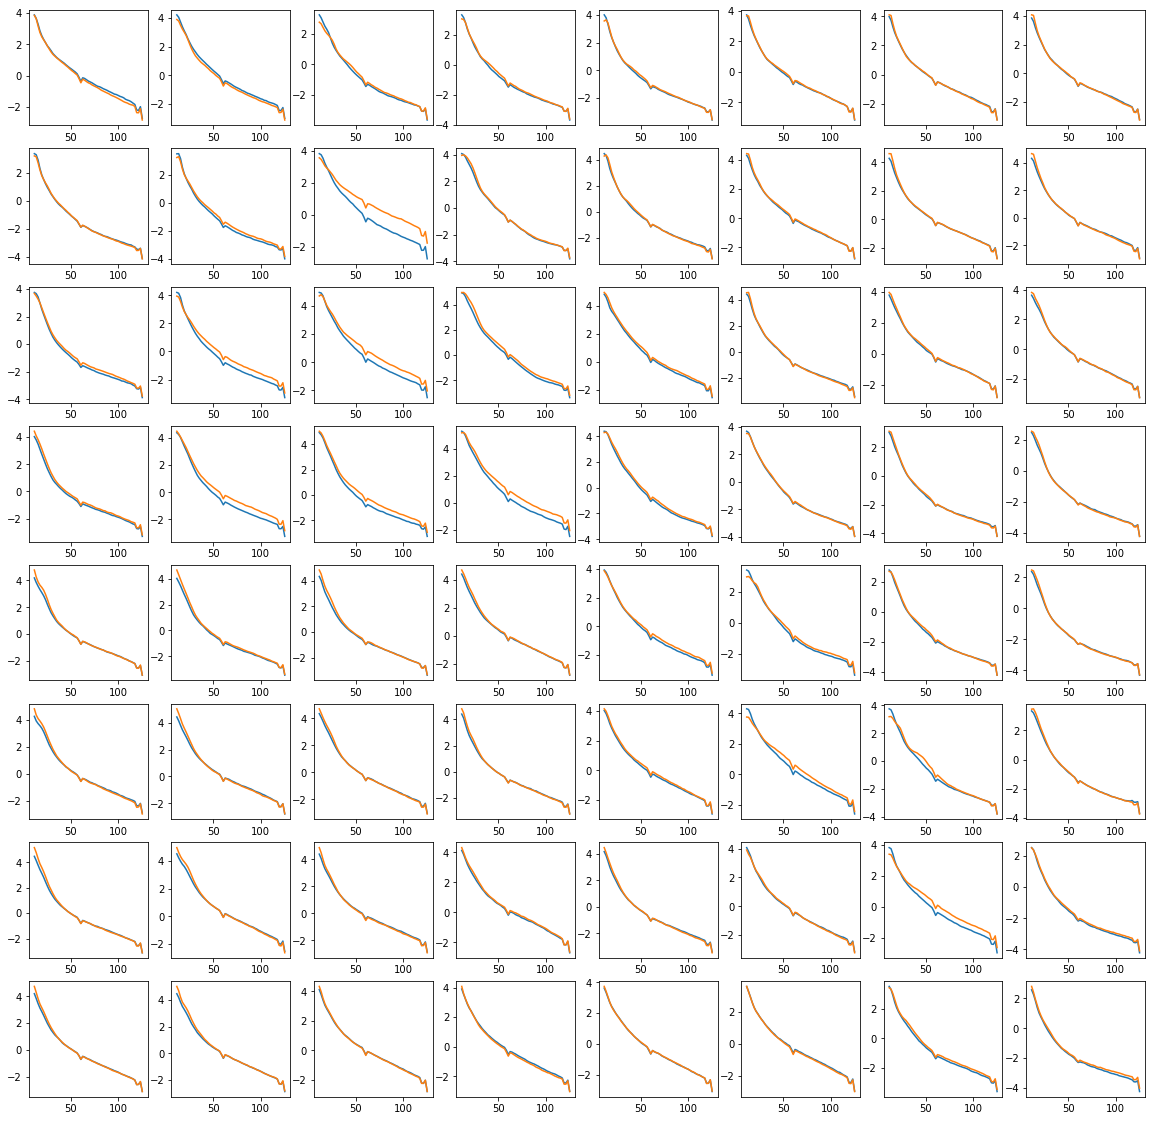

In [100]:
label1_mask = labels == 1
label2_mask = labels == 2

plt.figure(figsize=(20, 20))
for i_ch in range(n_chan):
    plt.subplot(8, 8, i_ch + 1)
    plt.plot(freqs, psd_data[label1_mask, i_ch, :].mean(axis=0))
    plt.plot(freqs, psd_data[label2_mask, i_ch, :].mean(axis=0))

### Train-test split

In [118]:
test_day = 4

mask_train = (events != test_day)
mask_test  = (events == test_day)

X_train, y_train = psd_data[mask_train, :, :], np.array(labels[mask_train] - 1)
X_test, y_test = psd_data[mask_test, :, :], np.array(labels[mask_test] - 1)

eps = 0.05
y_train[y_train == 0] = eps
y_train[y_train == 1] = 1 - eps
y_test[y_test == 0] = eps
y_test[y_test == 1] = 1 - eps

print(f" X_train: {X_train.shape} \n X_test:  {X_test.shape} \n y_train: {y_train.shape} \n y_test:  {y_test.shape} ")

 X_train: (1196, 64, 59) 
 X_test:  (154, 64, 59) 
 y_train: (1196,) 
 y_test:  (154,) 


### Creating data loaders

In [119]:
X_train = torch.tensor(X_train.reshape(-1, 8, 8, n_freqs)).permute(0, 3, 1, 2).float()
X_test  = torch.tensor(X_test.reshape(-1, 8, 8, n_freqs)).permute(0, 3, 1, 2).float()
        
y_train = torch.tensor(y_train).float()
y_test  = torch.tensor(y_test).float()

train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=8, shuffle=True)
test_loader  = DataLoader(list(zip(X_test, y_test)), batch_size=8, shuffle=True)

print(f" X_train: {X_train.shape} \n X_test:  {X_test.shape} \n y_train: {y_train.shape} \n y_test:  {y_test.shape} ")

 X_train: torch.Size([1196, 59, 8, 8]) 
 X_test:  torch.Size([154, 59, 8, 8]) 
 y_train: torch.Size([1196]) 
 y_test:  torch.Size([154]) 


### Initialize EcogNET model

In [148]:
class EcogNET(nn.Module):
    
    def __init__(self, n_chan=64, n_freqs=59):
        """
        EcogNET is designed to solve binary classification problem: 
        [Classify Movement/no-movement given ECoG data]
        
        The data used is AJILE12 preprocessed dataset version:
        https://figshare.com/projects/Generalized_neural_decoders_for_transfer_learning_across_participants_and_recording_modalities/90287
        
        The model processes input of shape (batch_size, n_freqs, 8, 8), 
        where (8, 8) is reshaped 64-electrode power-spectral density array of length n_freqs
        The axes are swaped using torch.permute to process different frequencies as separate channels for a 8x8 image
        
        Use print(EcogNET()) or summary(EcogNET(), input=(n_freqs, 8, 8)) to examine the model architecture.
        
        """
        super(EcogNET, self).__init__()
        
        # input: 
        # PSD batch_size x n_chan x n_freqs
        
        # it is possible to take into account the closeness of channels
        # -> put tensor of n_freqs x 8 x 8 into the NET
        
        self.conv1  = nn.Conv2d(in_channels=n_freqs, out_channels=64, kernel_size=3)  # make 6 x 6
        self.relu1  = nn.ReLU()
        self.bnorm1 = nn.BatchNorm2d(num_features=64)  # probably C is channels for B x C x H x W input
        
        self.conv2  = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)       # make 4 x 4
        self.bnorm2 = nn.BatchNorm2d(num_features=128)
        self.relu2  = nn.ReLU()
        
        self.conv3  = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1)       # keep 4 x 4
        self.bnorm3 = nn.BatchNorm2d(num_features=64)
        self.relu3  = nn.ReLU()
        
        # flatten (x.view)
        
        self.linear1  = nn.Linear(in_features=4 * 4 * 64, out_features=256)
        self.silu1    = nn.SiLU()
        self.dropout1 = nn.Dropout(p=0.2)
        
        self.linear2  = nn.Linear(in_features=256, out_features=16)
        self.silu2    = nn.SiLU()
        
        self.linear3  = nn.Linear(in_features=16, out_features=1)
        self.sigmoid  = nn.Sigmoid()
        
        
    def forward(self, x):
        
        # conv 8 x 8 -> 6 x 6
        out = self.conv1(x)
        out = self.relu1(out)
        
        # conv 6 x 6 -> 4 x 4
        out = self.conv2(out)
        out = self.bnorm2(out)
        out = self.relu2(out)
        
        # conv 4 x 4 -> 4 x 4
        out = self.conv3(out)
        out = self.bnorm3(out)
        out = self.relu3(out)
        
        # flatten before fully-connected
        out = out.reshape(-1, 64 * 4 * 4)
        
        # fully-conected
        out = self.linear1(out)
        out = self.silu1(out)
        out = self.dropout1(out)
        
        # 2nd layer
        out = self.linear2(out)
        out = self.silu2(out)
        
        # 3rd linear
        out = self.linear3(out)
        out = self.sigmoid(out)
        
        return out
        

#### Test EcogNET by feeding one sample

In [150]:
# initialize model
model = EcogNET().float().to(DEVICE)
print(model)

# feed one sample
x_sample = psd_data[0].reshape(8, 8, -1)
x_sample = torch.unsqueeze(torch.tensor(x_sample), 0)
x_sample = torch.permute(x_sample, (0, 3, 1, 2))
x_sample.shape

# print torchsummary
print(summary(model, x_sample.shape[1:]))

# test model.forward(x_sample)
print(f"Feeding a sample of shape {x_sample.shape}")
print(model(x_sample.to(DEVICE).float()))
print(f"Model {model.__class__.__name__} test succesffull")

EcogNET(
  (conv1): Conv2d(59, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (bnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (linear1): Linear(in_features=1024, out_features=256, bias=True)
  (silu1): SiLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=256, out_features=16, bias=True)
  (silu2): SiLU()
  (linear3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          

### Defining train, test and run functions

In [222]:
args = {'n_epochs': 200, 
        'device': DEVICE, 
        'lr': 1e-3, 
        'momentum': 0.9, 
        'lambda_l1': 0.1, 
        'lambda_l2': 0.1}

def train_nn(args, model, train_loader, optimizer, criterion):
    """
    Traines the model for one epoch
    Returns the trained model
    
    """
    device = args['device']
    
    model.train()
    
    for batch_idx, (X, y) in enumerate(train_loader):
        
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y.unsqueeze(1), y_hat)
        loss.backward()
        optimizer.step()
        
    return model


def test_nn(args, model, test_loader, criterion):
    """
    Calculates one epoch loss and accuracy
    
    """
    device = args['device']
    
    model.eval()
    
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for X, y in test_loader:
            
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            
            test_loss += criterion(y.unsqueeze(1), y_hat, reduction='sum').item()
            
            y[y >= 0.5] = 1
            y[y < 0.5] = 0
            
            y_hat[y_hat >= 0.5] = 1
            y_hat[y_hat < 0.5] = 0
            
            correct += float(torch.sum(y == y_hat.squeeze()))
            
        test_loss /= len(test_loader.dataset)
        accuracy = correct / len(test_loader.dataset)
         
    return test_loss, accuracy
    
    
def run_nn(args, model, train_loader, test_loader):
    """
    Trains the model with train_loader and
    tests the learned model using val_loader

    Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Train dataset
    test_loader: torch.loader
      Validation set

    Returns:
    test_acc_list: list
      Log of validation accuracy
    train_acc_list: list
      Log of training accuracy
    trained_model: nn.module
      Trained model/model post training
    """

    device = args['device']

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])
    # criterion = lambda y1, y2: F.binary_cross_entropy(y1, y2) + \
    #                             args['lambda_l1'] * F.l1_loss(y1, y2) + \
    #                             args['lambda_l2'] * F.mse_loss(y1, y2)
    
    criterion = F.binary_cross_entropy

    test_acc_list, train_acc_list, test_loss_list, train_loss_list = [], [], [], []
    for epoch in tqdm(range(args['n_epochs']), desc='Epochs'):
        
        trained_model = train_nn(args, model, train_loader, optimizer, criterion)
        
        train_loss, train_acc = test_nn(args, trained_model, train_loader, criterion)
        test_loss, test_acc   = test_nn(args, trained_model, test_loader, criterion)
        
        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
    trained_model._performance = {'test_acc': test_acc_list, 
                                  'train_acc': train_acc_list, 
                                  'test_loss': test_loss_list, 
                                  'train_loss': train_loss_list}

    return test_acc_list, train_acc_list, test_loss_list, train_loss_list, trained_model
        

In [132]:
print(model)

EcogNET(
  (conv1): Conv2d(59, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (bnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=1024, out_features=256, bias=True)
  (silu1): SiLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (linear2): Linear(in_features=256, out_features=16, bias=True)
  (silu2): SiLU()
  (linear3): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [138]:
summary(EcogNET().float().to(DEVICE), (59, 8, 8))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 32, 6, 6]          17,024
              ReLU-2             [-1, 32, 6, 6]               0
       BatchNorm2d-3             [-1, 32, 6, 6]              64
            Conv2d-4             [-1, 64, 4, 4]          18,496
              ReLU-5             [-1, 64, 4, 4]               0
       BatchNorm2d-6             [-1, 64, 4, 4]             128
            Linear-7                  [-1, 256]         262,400
              SiLU-8                  [-1, 256]               0
           Dropout-9                  [-1, 256]               0
           Linear-10                   [-1, 16]           4,112
             SiLU-11                   [-1, 16]               0
           Linear-12                    [-1, 1]              17
          Sigmoid-13                    [-1, 1]               0
Total params: 302,241
Trainable params:

### Running the model

In [196]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

DEVICE = set_device()

args = {'n_epochs': 200, 
        'device': DEVICE, 
        'lr': 1e-3, 
        'momentum': 0.9, 
        'lambda_l1': 0.1, 
        'lambda_l2': 0.1}

model = EcogNET().float().to(DEVICE)

test_acc_list, train_acc_list, test_loss_list, train_loss_list, trained_model = run_nn(args, model, train_loader, test_loader)

GPU is enabled in this notebook.


Epochs: 100%|████████████████████████████████████████████████████████████████████████| 200/200 [11:43<00:00,  3.52s/it]


#### Accuracy and loss plots

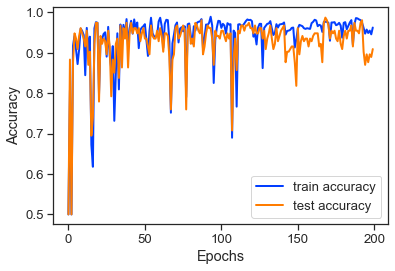

In [197]:
plt.plot(np.arange(args['n_epochs']), train_acc_list, label='train accuracy', linewidth=2)
plt.plot(np.arange(args['n_epochs']), test_acc_list, label='test accuracy', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()

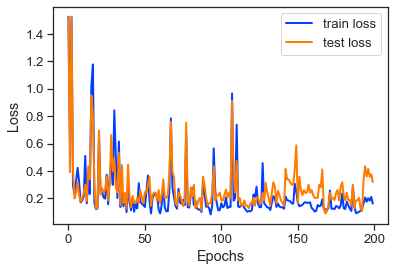

In [217]:
plt.plot(np.arange(args['n_epochs']), train_loss_list, label='train loss', linewidth=2)
plt.plot(np.arange(args['n_epochs']), test_loss_list, label='test loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

#### Saving the model to pickle

In [221]:
model_fname = "baseline_classification_model.pickle"

with open(model_fname, 'wb') as f:
    pickle.dump(model, f)

### Writing alternative simple MLP

In [93]:
class SomeNET(nn.Module):
    # receives input of shape n_freqs
    def __init__(self):
        
        super(SomeNET, self).__init__()
        
        self.fc1 = nn.Linear(59 * 8 * 8, 64)
        self.act1 = nn.SiLU()
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = x.reshape(-1, 59 * 8 * 8)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out)
        # out = self.sigmoid(out)
        return out

In [225]:
class SomeNET2(nn.Module):
    # receives input of shape n_freqs
    def __init__(self):
        
        super(SomeNET, self).__init__()
        
        self.fc1 = nn.Linear(59 * 8 * 8, 8)
        self.act1 = nn.Sigmoid()
        self.fc2 = nn.Linear(8, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = x.reshape(-1, 59 * 8 * 8)
        out = self.fc1(out)
        out = self.act1(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [224]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "0"

DEVICE = set_device()

args = {'n_epochs': 200, 
        'device': DEVICE, 
        'lr': 1e-3, 
        'momentum': 0.9, 
        'lambda_l1': 0.1, 
        'lambda_l2': 0.1}

model = SomeNET().float().to(DEVICE)

test_acc_list, train_acc_list, test_loss_list, train_loss_list, trained_model = run_nn(args, model, train_loader, test_loader)

GPU is enabled in this notebook.


Epochs: 100%|████████████████████████████████████████████████████████████████████████| 200/200 [03:25<00:00,  1.03s/it]


#### Accuracy and loss plots

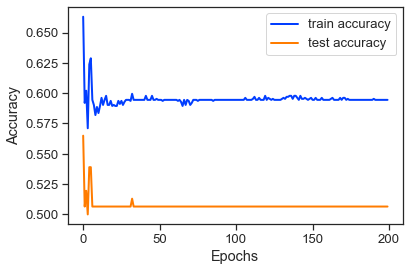

In [226]:
plt.plot(np.arange(args['n_epochs']), train_acc_list, label='train accuracy', linewidth=2)
plt.plot(np.arange(args['n_epochs']), test_acc_list, label='test accuracy', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend()

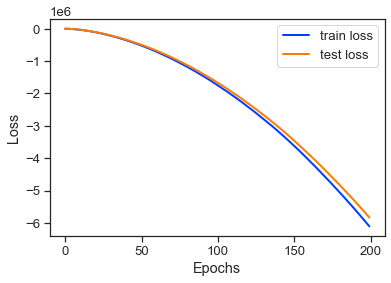

In [227]:
plt.plot(np.arange(args['n_epochs']), train_loss_list, label='train loss', linewidth=2)
plt.plot(np.arange(args['n_epochs']), test_loss_list, label='test loss', linewidth=2)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend()

In [228]:
print(model)

SomeNET(
  (fc1): Linear(in_features=3776, out_features=64, bias=True)
  (act1): SiLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


### Debugging

In [122]:
#model = EcogNET(n_chan, n_freqs).float()
model = EcogNET().float()

args = {'n_epochs': 10, 
        'device': 'cpu', 
        'lr': 1e-3, 
        'momentum': 0.9, 
        'lambda_l1': 0.1, 
        'lambda_l2': 0.1}

device = args['device']

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=args['lr'])

# criterion = lambda y1, y2: F.binary_cross_entropy(y1, y2) + \
#                             args['lambda_l1'] * F.l1_loss(y1, y2) + \
#                             args['lambda_l2'] * F.mse_loss(y1, y2)

criterion = F.binary_cross_entropy

device = args['device']

model.train()
with torch.autograd.detect_anomaly():
    for batch_idx, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_hat = model(X)
        print("Truth: ", y)
        print("Prediction, ", y_hat.squeeze())
        loss = criterion(y.unsqueeze(1), y_hat)
        print("Loss: ", loss)
        loss.backward()
        optimizer.step()

C:\Users\aleks\AppData\Local\Temp\ipykernel_26104\416187120.py:26: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with torch.autograd.detect_anomaly():


RuntimeError: size mismatch, got 256, 256x1024,8192

In [80]:
y

tensor([1., 1., 1., 0., 0., 0., 0., 0.])

In [78]:
y_hat.squeeze()

tensor([0.4654, 0.4340, 0.4150, 0.4003, 0.4225, 0.3871, 0.4309, 0.4295],
       grad_fn=<SqueezeBackward0>)

In [159]:
for X, y in train_loader:
    X = X
    y = y
    break
    
y.shape

torch.Size([4])

In [138]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

model.linear1.register_forward_hook()

AttributeError: 'SomeNET' object has no attribute 'linear1'

### ** W2D1 tutorial funcs

In [112]:
def train(args, model, train_loader, optimizer,
          reg_function1=None, reg_function2=None, criterion=F.nll_loss):
    """
    Trains the current input model using the data
    from Train_loader and Updates parameters for a single pass

    Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Input dataset
    optimizer: function
      Optimizer
    reg_function1: function
      Regularisation function [default: None]
    reg_function2: function
      Regularisation function [default: None]
    criterion: function
      Specifies loss function [default: nll_loss]

    Returns:
    model: nn.module
      Neural network instance post training
    """
    device = args['device']
    
    model.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        
        if reg_function1 is None:
            loss = criterion(output, target)
        elif reg_function2 is None:
            loss = criterion(output, target)+args['lambda']*reg_function1(model)
        else:
            loss = criterion(output, target) + args['lambda1']*reg_function1(model) + args['lambda2']*reg_function2(model)
        loss.backward()
        optimizer.step()

    return model


def test(model, test_loader, criterion=F.nll_loss, device='cpu'):
    """
    Tests the current model

    Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    test_loader: torch.loader
      Test dataset
    criterion: function
      Specifies loss function [default: nll_loss]

    Returns:
    test_loss: float
      Test loss
    """
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
    return 100. * correct / len(test_loader.dataset)


def main(args, model, train_loader, val_loader,
         reg_function1=None, reg_function2=None):
    """
    Trains the model with train_loader and
    tests the learned model using val_loader

    Args:
    args: dictionary
      Dictionary with epochs: 200, lr: 5e-3, momentum: 0.9, device: DEVICE
    model: nn.module
      Neural network instance
    train_loader: torch.loader
      Train dataset
    val_loader: torch.loader
      Validation set
    reg_function1: function
      Regularisation function [default: None]
    reg_function2: function
      Regularisation function [default: None]

    Returns:
    val_acc_list: list
      Log of validation accuracy
    train_acc_list: list
      Log of training accuracy
    param_norm_list: list
      Log of frobenius norm
    trained_model: nn.module
      Trained model/model post training
    """

    device = args['device']

    model = model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=args['lr'],
                        momentum=args['momentum'])

    val_acc_list, train_acc_list,param_norm_list = [], [], []
    for epoch in tqdm(range(args['epochs'])):
        trained_model = train(args, model, train_loader, optimizer,
                              reg_function1=reg_function1,
                              reg_function2=reg_function2)
        train_acc = test(trained_model, train_loader, device=device)
        val_acc = test(trained_model, val_loader, device=device)
        param_norm = calculate_frobenius_norm(trained_model)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        param_norm_list.append(param_norm)

    return val_acc_list, train_acc_list, param_norm_list, trained_model